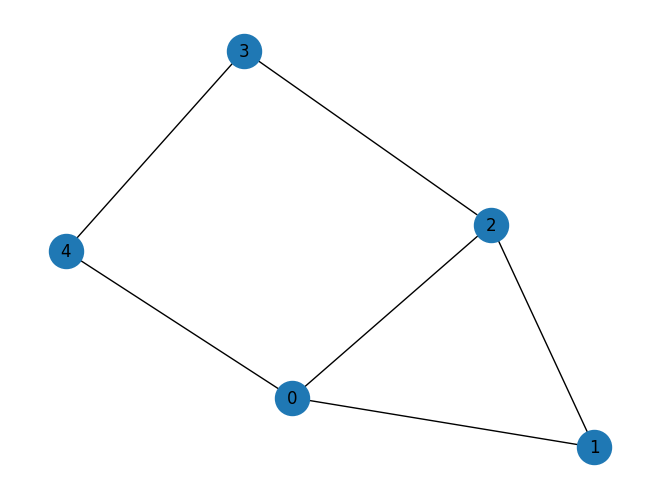

In [1]:
import numpy as np

import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np

import sys
sys.path.append("../")
from clapton.clapton import claptonize
from clapton.ansatzes import circular_ansatz
from clapton.circuit_manipulation import transform_to_allowed_gates,qiskit_to_stim

n = 5

graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 4, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0)]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

In [2]:
from qiskit.quantum_info import SparsePauliOp
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list


max_cut_paulis = build_max_cut_paulis(graph)

cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


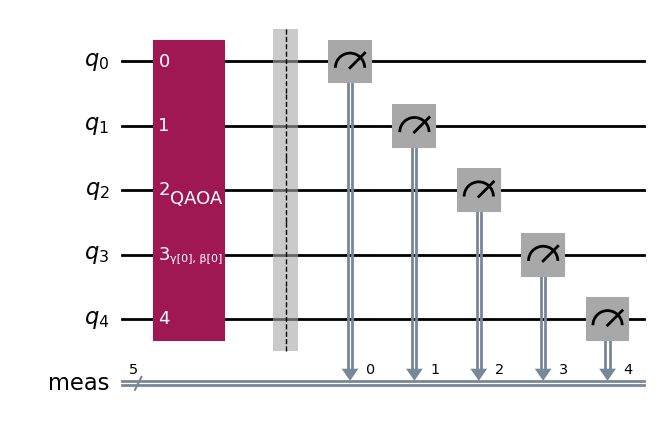

In [3]:
from qiskit.circuit.library import QAOAAnsatz

reps = 1
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=reps)
circuit.measure_all()

circuit.draw('mpl')

In [4]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(γ[0])])

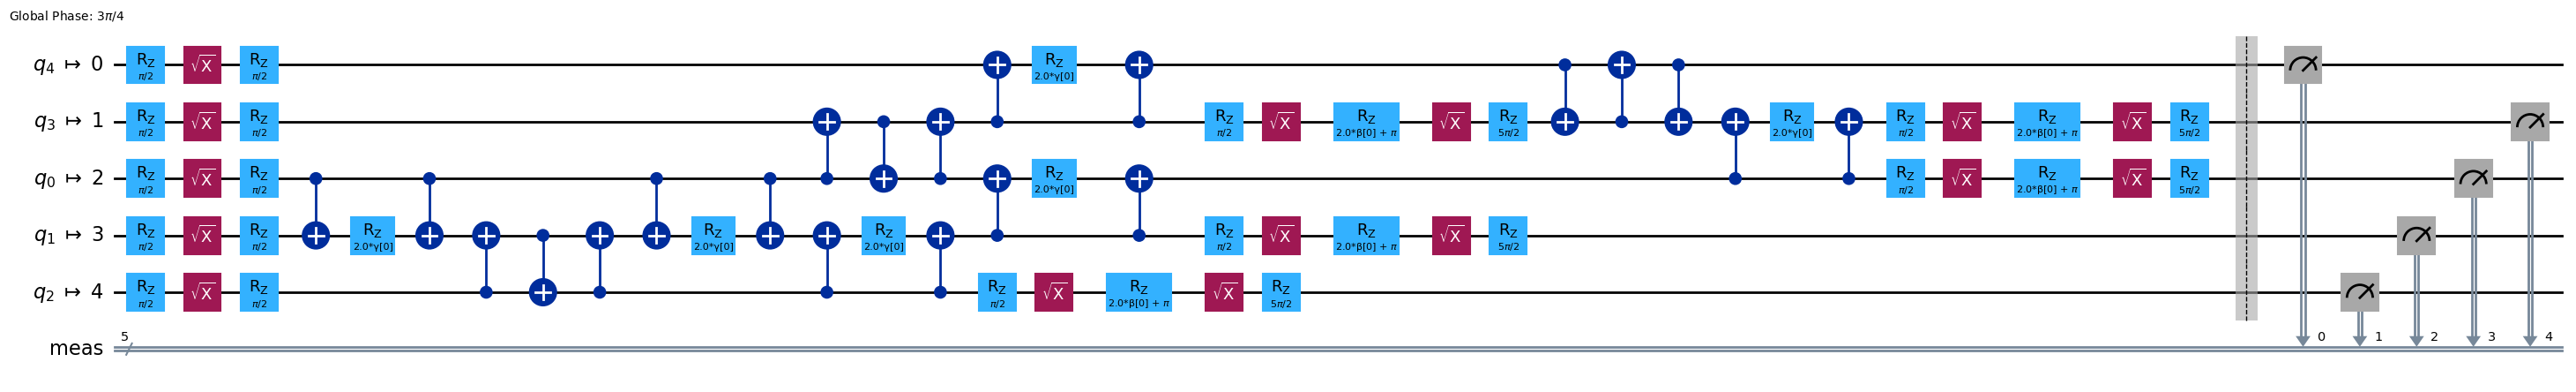

In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeManilaV2


# QiskitRuntimeService.save_account(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>", overwrite=True, set_as_default=True)
# service = QiskitRuntimeService(channel='ibm_quantum')
# backend = service.least_busy(min_num_qubits=127)

backend = FakeManilaV2()

print(backend)

# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=backend)

candidate_circuit = pm.run(circuit)
candidate_circuit.draw('mpl', fold=False, idle_wires=False)

In [8]:
# from qiskit.converters import circuit_to_dag
# dag = circuit_to_dag(candidate_circuit)
# for node in dag.topological_op_nodes():
    # if len(node.params) != 0:
    #     if (type(node.params[0])) is not float:
    #         print(node.params)

pcirc = transform_to_allowed_gates(candidate_circuit)
stim_circ = qiskit_to_stim(pcirc)
# for instruction in pcirc:
#     if instruction.operation.name.upper() == "U1":
#         print(instruction.operation.params[0])

stim_circ.stim_circuit().diagram()


q0: -S-S_DAG-H-S_DAG-S-----------------------------------------------------------------------------------------X-I-X-----------------------------------@-X-@---------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                               |   |                                   | | |
q1: -----------------S-S_DAG-H-S_DAG-S-------------------------------------------------------------------X-@-X-@---@-S-S_DAG-H-S_DAG-I-S_DAG-H-S_DAG-S-X-@-X-----------X-I-X-S-S_DAG-H-S_DAG-I-S_DAG-H-S_DAG-S-------------------------------------------------------------------------------------------------
                                                                                                         | | |                                                         |   |
q2: ---------------------------------S-S_DAG-H-S_DAG-S-----------------@---@-----------------------@---@-@-X-@---------------------------------------------------X-I-X-@---@---------------------------------S-S_DAG-H-S_DAG-I-S_DAG-H-S_DAG-S-----------------------------------------------------------------
                                                                       |   |                       |   |                                                         |   |
q3: -------------------------------------------------S-S_DAG-H-S_DAG-S-X-I-X-----------------X-@-X-X-I-X---------------------------------------------------X-I-X-@---@-----------------------------------------------------------------------S-S_DAG-H-S_DAG-I-S_DAG-H-S_DAG-S---------------------------------
                                                                                             | | |                                                         |   |
q4: -----------------------------------------------------------------------S-S_DAG-H-S_DAG-S-@-X-@---------------------------------------------------------@---@-------------------------------------------------------------------------------------------------------------S-S_DAG-H-S_DAG-I-S_DAG-H-S_DAG-S-

In [71]:
# (np.pi/2 * 5) // (np.pi/2)

def rotations_needed(theta):
    return (theta % (2 * np.pi)) // (np.pi / 2)

theta = 3 * np.pi / 2  # Example input
print(int(rotations_needed(theta)))

3


In [7]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta] * reps

In [7]:
objective_func_vals = []

def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    global objective_func_vals

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)


    return cost

In [28]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from scipy.optimize import minimize

objective_func_vals = [] # Global variable
# with Session(backend=backend) as session:
#     # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
#     estimator = Estimator(mode=session)
#     estimator.options.default_shots = 1000

#     # Set simple error suppression/mitigation options
#     estimator.options.dynamical_decoupling.enable = True
#     estimator.options.dynamical_decoupling.sequence_type = "XY4"
#     estimator.options.twirling.enable_gates = True
#     estimator.options.twirling.num_randomizations = "auto"

#     result = minimize(
#         cost_func_estimator,
#         init_params,
#         args=(candidate_circuit, cost_hamiltonian, estimator),
#         method="COBYLA",
#         tol=1e-2,
#     )
#     print(result)


estimator = Estimator(mode=backend)

result = minimize(
    cost_func_estimator,
    init_params,
    args=(candidate_circuit, cost_hamiltonian, estimator),
    method="COBYLA",
    tol=1e-3,
)
print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.62548828125
       x: [ 4.832e+00  1.154e+00  2.527e+00  2.748e+00]
    nfev: 36
   maxcv: 0.0


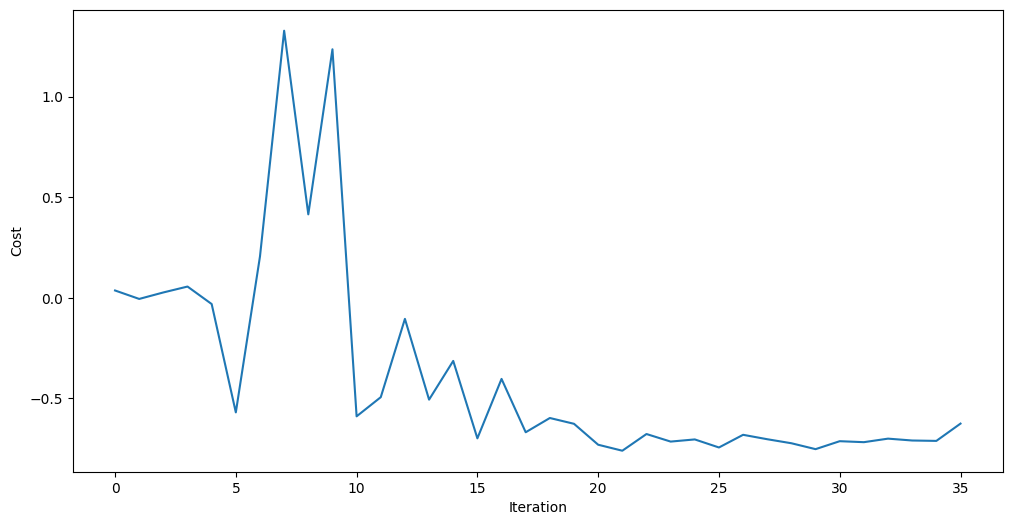

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

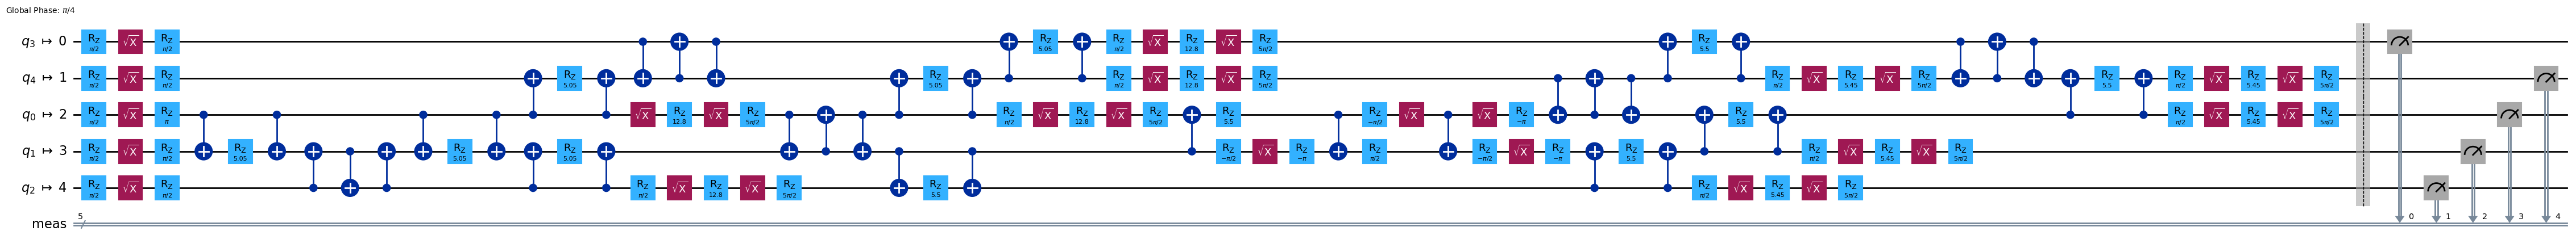

In [30]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw('mpl', fold=False, idle_wires=False)

In [31]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000

# # Set simple error suppression/mitigation options
# sampler.options.dynamical_decoupling.enable = True
# sampler.options.dynamical_decoupling.sequence_type = "XY4"
# sampler.options.twirling.enable_gates = True
# sampler.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)

{14: 0.0337, 4: 0.0279, 10: 0.0576, 26: 0.0405, 3: 0.0157, 23: 0.0251, 13: 0.0604, 16: 0.0301, 5: 0.0439, 18: 0.0673, 11: 0.035, 2: 0.0321, 15: 0.0249, 8: 0.0282, 6: 0.0157, 9: 0.0362, 17: 0.0372, 19: 0.0353, 25: 0.0128, 21: 0.0576, 12: 0.0385, 1: 0.028, 30: 0.0221, 27: 0.0223, 0: 0.0154, 7: 0.0168, 24: 0.0171, 22: 0.0353, 20: 0.0388, 29: 0.0254, 28: 0.0157, 31: 0.0074}


In [32]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(graph))
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [0, 1, 0, 0, 1]


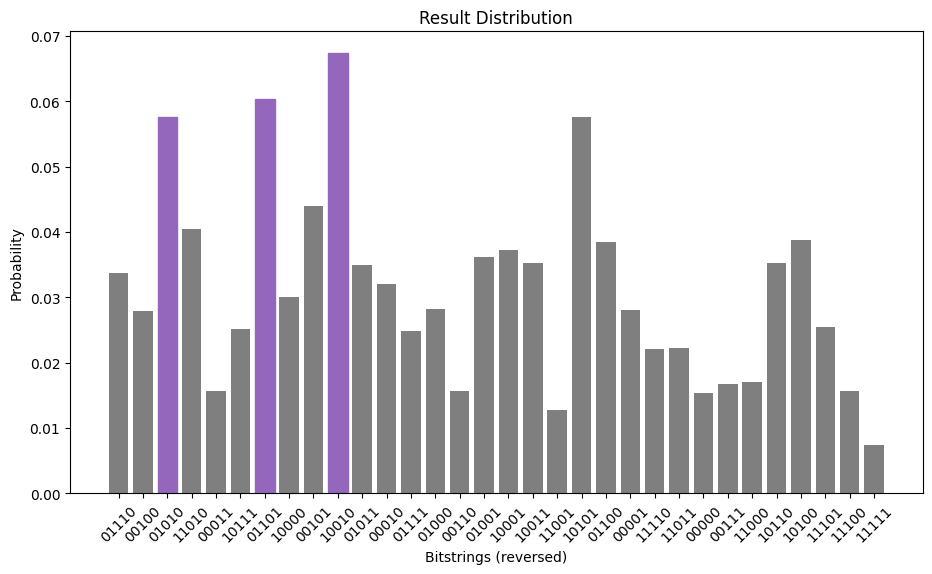

In [33]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0][0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
plt.show()

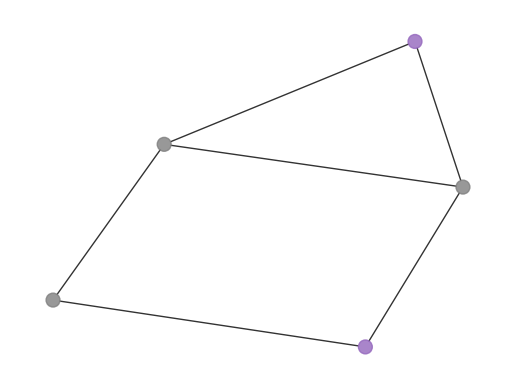

In [34]:
# auxiliary function to plot graphs
def plot_result(G, x):
    colors = ["tab:grey" if i == 0 else "tab:purple" for i in x]
    pos, default_axes = rx.spring_layout(G), plt.axes(frameon=True)
    rx.visualization.mpl_draw(G, node_color=colors, node_size=100, alpha=0.8, pos=pos)

plot_result(graph, most_likely_bitstring)

In [35]:
from typing import Sequence
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(list(graph.nodes())), "The length of x must coincide with the number of nodes in the graph."
    return sum(x[u] * (1 - x[v]) + x[v] * (1 - x[u]) for u, v in list(graph.edge_list()))


cut_value= evaluate_sample(most_likely_bitstring, graph)
print('The value of the cut is:', cut_value)

The value of the cut is: 4
